In [1]:
import pylab as pl
import scipy as sp
from numpy.linalg import inv
from numpy.linalg import solve
from scipy.io import loadmat
import pdb
import numpy as np
from scipy.spatial.distance import cdist
%matplotlib inline

In [2]:
def load_data(fname):
    ''' Loads EMG data from <fname> '''
    # load the data
    data = loadmat(fname)
    # extract data for training
    X_train = data['training_data']
    X_train = sp.log(X_train)
    X_train = X_train[:, :1000]
    # extract hand positions
    Y_train = data['training_labels']
    Y_train = Y_train[:, :1000]
    return X_train,Y_train


In [3]:
def GaussianKernel(X1, X2, kwidth):
    ''' Compute Gaussian Kernel 
    Input: X1    - DxN1 array of N1 data points with D features 
           X2    - DxN2 array of N2 data points with D features 
           kwidth - Kernel width
    Output K     - N1 x N2 Kernel matrix
    '''
    assert(X1.shape[0] == X2.shape[0])
    K = cdist(X1.T, X2.T, 'euclidean')
    K = np.exp(-(K ** 2) / (2. * kwidth ** 2))
    return K

In [4]:
def train_krr(X_train, Y_train,kwidth,llambda):
    ''' Trains kernel ridge regression (krr)
    Input:       X_train  -  DxN array of N data points with D features
                 Y        -  D2xN array of length N with D2 multiple labels
                 kwdith   -  kernel width
                 llambda    -  regularization parameter
    Output:      alphas   -  NxD2 array, weighting of training data used for apply_krr                     
    '''
    # your code here
    K = GaussianKernel(X_train, X_train, kwidth)
    KLI = (K + np.diag(llambda * np.ones(len(K))))
    alphas = np.linalg.inv(KLI).dot(Y_train.T)
    return alphas

In [5]:
def apply_krr(alphas, X_train, X_test, kwidth):
    ''' Applys kernel ridge regression (krr)
    Input:      alphas      -  NtrxD2 array trained in train_krr      
                X_train     -  DxNtr array of Ntr train data points with D features
                X_test      -  DxNte array of Nte test data points with D features
                kwidht      -  Kernel width             
    Output:     Y_test      -  D2xNte array
    '''
    # your code here
    k = GaussianKernel(X_test, X_train, kwidth)
    return k.dot(alphas).T

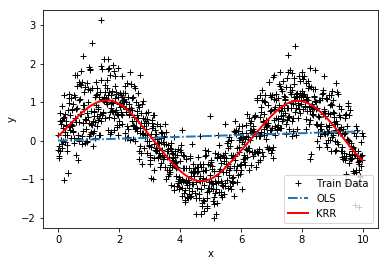

In [43]:
test_sine_toydata()

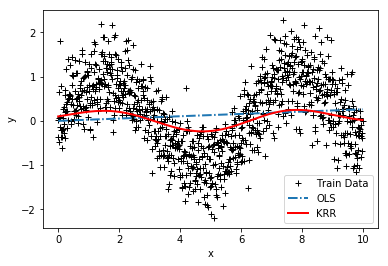

In [100]:
test_sine_toydata(kwidth=1, llambda=500)

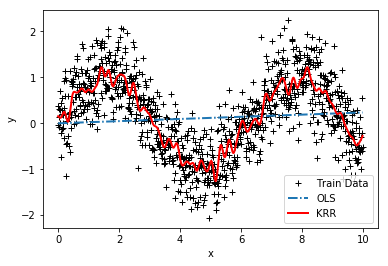

In [99]:
test_sine_toydata(kwidth=.1, llambda=1)

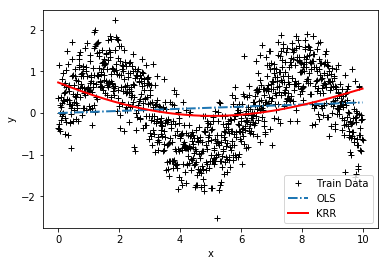

In [98]:
test_sine_toydata(kwidth=10, llambda=1)

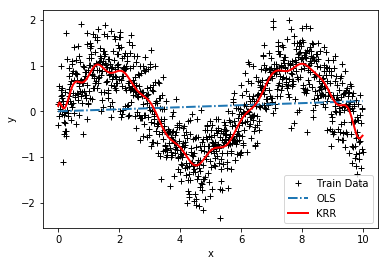

In [47]:
test_sine_toydata(kwidth=1, llambda=10**(-10))

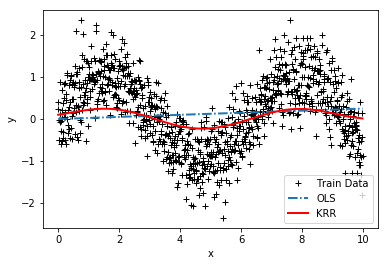

In [48]:
test_sine_toydata(kwidth=1, llambda=500)

Fold 0 best kernel width 10.000000 best regularizer 0.010000 rsquare 0.964582 rsquare linear 0.925907
Fold 1 best kernel width 10.000000 best regularizer 0.010000 rsquare 0.954383 rsquare linear 0.917024
Fold 2 best kernel width 10.000000 best regularizer 0.010000 rsquare 0.960622 rsquare linear 0.923300
Fold 3 best kernel width 10.000000 best regularizer 0.010000 rsquare 0.956080 rsquare linear 0.917532
Fold 4 best kernel width 10.000000 best regularizer 0.010000 rsquare 0.957619 rsquare linear 0.913997


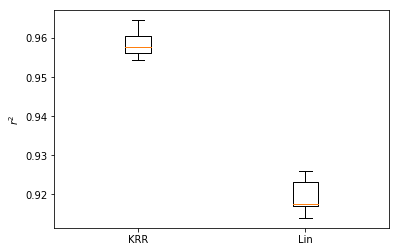

In [49]:
test_handpositions()

In [6]:
def train_ols(X_train, Y_train):
    ''' Trains ordinary least squares (ols) regression 
    Input:       X_train  -  DxN array of N data points with D features
                 Y        -  D2xN array of length N with D2 multiple labels
    Output:      W        -  DxD2 array, linear mapping used to estimate labels 
                             with sp.dot(W.T, X)                      
    '''
    #W = sp.dot(inv(sp.dot(X_train,X_train.T)),sp.dot(X_train,Y_train.T))
    W = solve(sp.dot(X_train,X_train.T),sp.dot(X_train,Y_train.T))
    return W
    

In [7]:
def apply_ols(W, X_test):
    ''' Applys ordinary least squares (ols) regression 
    Input:       X_test    -  DxN array of N data points with D features
                 W        -  DxD2 array, linear mapping used to estimate labels 
                             trained with train_ols                   
    Output:     Y_test    -  D2xN array
    '''
    Y_test = sp.dot(W.T, X_test)
    return Y_test
	

In [8]:
def test_handpositions():
    X,Y = load_data('myo_data.mat')
    crossvalidate_krr(X,Y)
	

In [9]:
def test_sine_toydata(kwidth = 1, llambda = 1):
	#Data generation
    X_train = sp.arange(0,10,.01)
    X_train = X_train[None,:]
    Y_train = sp.sin(X_train) + sp.random.normal(0,.5,X_train.shape)
    #Linear Regression 
    w_est = train_ols(X_train, Y_train) 
    Y_est_lin = apply_ols(w_est,X_train)
    #Kernel Ridge Regression
    alphas = train_krr(X_train,Y_train,kwidth,llambda)
    Y_est_krr = apply_krr(alphas,X_train,X_train,kwidth)
    
    #Plot result
    pl.figure()
    pl.plot(X_train.T, Y_train.T, '+k', label = 'Train Data')
    pl.plot(X_train.T, Y_est_lin.T, '-.', linewidth = 2, label = 'OLS')
    pl.plot(X_train.T, Y_est_krr.T,  'r', linewidth = 2, label = 'KRR')
    pl.xlabel('x')
    pl.ylabel('y')
    pl.legend(loc = 'lower right')
    
      

In [10]:
def crossvalidate_krr(X,Y,f=5, kwidths=10.0**np.array([0, 1, 2]), llambdas=10.0**np.array([-4, -2, 0])):
    ''' 
    Test generalization performance of kernel ridge regression with gaussian kernel
    Input:	    X	data (dims-by-samples)
    			Y	labels (dims2-by-samples)
    			f	number of cross-validation folds
    			kwidths width of gaussian kernel function 
    			llambdas regularizer (height of ridge on kernel matrix)
    '''
    N = f*(X.shape[-1]/f)
    idx = sp.reshape(sp.random.permutation(sp.arange(N)),(f,N/f))
    r2_outer = sp.zeros((f))
    r2_linear = sp.zeros((f))
    r2_inner = sp.zeros((f-1,kwidths.shape[-1],llambdas.shape[-1]))
    
    # to outer cross-validation (model evaluation)
    for ofold in range(f):
        # split in training and test (outer fold)
        otestidx = sp.zeros((f),dtype=bool)
        otestidx[ofold] = 1
        otest = idx[otestidx,:].flatten()
        otrain = idx[~otestidx,:]
        
        # inner cross-validation (model selection)
        for ifold in range(f-1):
            # split in training and test (inner fold)
            itestidx = sp.zeros((f-1),dtype=bool)
            itestidx[ifold] = 1
            itest = otrain[itestidx,:].flatten()
            itrain = otrain[~itestidx,:].flatten()
            
            # do inner cross-validation (model selection)
            for illambda in range(llambdas.shape[-1]):
                for ikwidth in range(kwidths.shape[-1]):
                    #compute kernel for all data points
                    alphas = train_krr(X[:,itrain],Y[:,itrain],kwidths[ikwidth],llambdas[illambda])
                    yhat = apply_krr(alphas, X[:,itrain], X[:,itest],kwidths[ikwidth])
                    r2_inner[ifold,ikwidth,illambda] = compute_rsquare(yhat,Y[:,itest])

        #train again using optimal parameters
        r2_across_folds = r2_inner.mean(axis=0)
        optkwidthidx, optllambdaidx = np.unravel_index(r2_across_folds.flatten().argmax(),r2_across_folds.shape)
        #evaluate model on outer test fold
        alphas = train_krr(X[:,otrain.flatten()],Y[:,otrain.flatten()], kwidths[optkwidthidx],llambdas[optllambdaidx])
        yhat = apply_krr(alphas, X[:,otrain.flatten()],X[:,otest], kwidths[optkwidthidx])
        r2_outer[ofold] = compute_rsquare(yhat,Y[:,otest])
        				
        # for comparison: predict with linear model
        w_est = train_ols(X[:,otrain.flatten()], Y[:,otrain.flatten()]) 
        y_est_lin = apply_ols(w_est,X[:,otest])
        r2_linear[ofold] = compute_rsquare(y_est_lin,Y[:,otest])
        
        print 'Fold %d'%ofold + ' best kernel width %f'%kwidths[optkwidthidx] +\
        ' best regularizer %f'%llambdas[optllambdaidx] + \
        ' rsquare %f'%r2_outer[ofold] + \
        ' rsquare linear %f'%r2_linear[ofold]
    pl.figure()
    pl.boxplot(sp.vstack((r2_outer,r2_linear)).T)
    pl.ylabel('$r^2$')
    pl.xticks((1,2),('KRR','Lin'))
    pl.savefig('krr_vs_lin_comparison.pdf')
    return r2_outer,r2_linear
    

In [11]:

def compute_rsquare(yhat,Y):
    '''compute coefficient of determination'''
    return 1 - (sp.var((yhat - Y),axis=1).sum()/sp.var(Y,axis=1).sum())

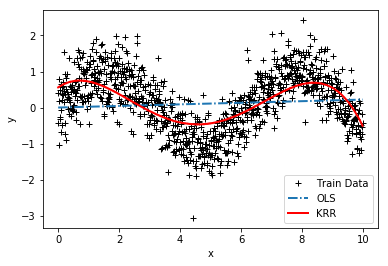

In [52]:
test_sine_toydata(kwidth=100, llambda=.00000000001)

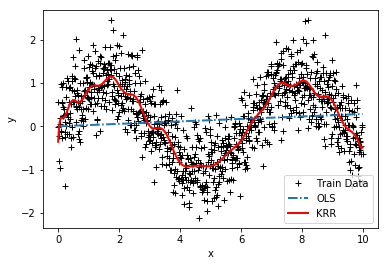

In [68]:
test_sine_toydata(llambda=.000000000001)

Fold 0 best kernel width 10.000000 best regularizer 0.010000 rsquare 0.957221 rsquare linear 0.916177
Fold 1 best kernel width 10.000000 best regularizer 0.010000 rsquare 0.965088 rsquare linear 0.906724
Fold 2 best kernel width 10.000000 best regularizer 0.010000 rsquare 0.954008 rsquare linear 0.924322
Fold 3 best kernel width 10.000000 best regularizer 0.010000 rsquare 0.963379 rsquare linear 0.918913
Fold 4 best kernel width 10.000000 best regularizer 0.010000 rsquare 0.954916 rsquare linear 0.921465


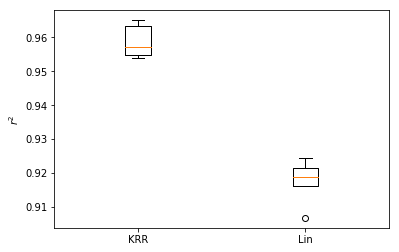

In [12]:
test_handpositions()

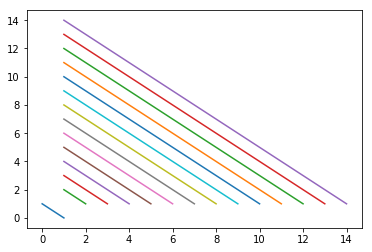

In [67]:
for i in range(15):
    pl.plot([i,1],[1,i])

In [164]:
dataset = np.random.normal(0,1,[2,100])
dataset = np.diag([8,1]).dot(dataset)
dataset = np.array([[.5,-.85],[.85,.5]]).dot(dataset)
m, b = np.random.normal(0,1,[2])


(-22.0, 22.0, -14.504357253156945, 17.433668507477762)

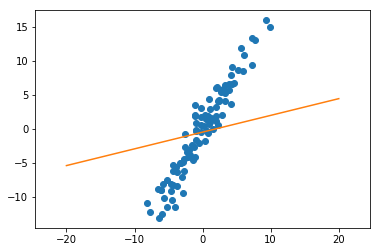

In [171]:
pl.plot(dataset[0], dataset[1], 'o')
pl.plot([-20,20],[m*20 + b, -m*20 + b])
pl.axis('equal')

In [220]:
errors = []
def adjust_via_GD(m, b, dataset, rate, errors):
    error_b = sum([b - x[1] + m * x[0] for x in dataset.T ]) / float(len(dataset.T))
    error_m = sum([b * x[0] - x[0] * x[1] + m * x[0] * x[0] for x in dataset.T ]) / float(len(dataset.T))
    errors += [-error_b - error_m]
    return m - error_m * rate, b - error_b * rate

In [221]:
dataset.T[1]

array([-3.27495333, -4.93921202])

In [222]:
len(dataset)

2

(-0.42091657277506123, -1.005669150157988)
(1.6532996318379658, 0.029851611340358648)


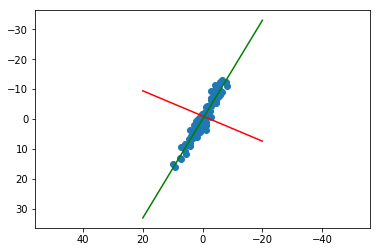

In [238]:
m, b = np.random.normal(0,1,[2])
print(m, b)
pl.xlim(30)
pl.ylim(30)
pl.axis('equal')
pl.plot(dataset[0], dataset[1], 'o')
pl.plot([-20,20],[-m*20 + b, m*20 + b], 'r')
#m, b = adjust_via_GD(m, b, dataset, .05, errors)
#pl.plot([-20,20],[-m*20 + b, m*20 + b], 'y')
for i in range(500):
    m, b = adjust_via_GD(m, b, dataset, .05, errors)
pl.plot([-20,20],[-m*20 + b, m*20 + b], 'g')
print(m, b)

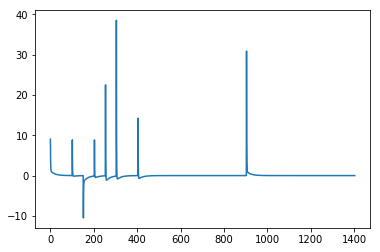

In [239]:
pl.plot(np.arange(len(errors)), errors)

In [240]:
f = open('train.csv','r')
for line in f:
    print f

IOError: [Errno 2] No such file or directory: 'train.csv'